In [1]:
using Revise
using DifferentialEquations
using Flux
using DiffEqFlux
using Optim
using Plots
using FileIO
using JLD2
using OffsetArrays

include("/mnt/d/Coding/Github/Kinetic.jl/src/Kinetic.jl")
using .Kinetic

In [2]:
function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [3]:
D = read_dict("../code/shock/shock1D.txt")
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d1f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.95
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 50
pMeshType = uniform
nxg = 0
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vMeshType = rectangle
knudsen = 1.0
mach = 3.0
prandtl = 1.0
inK = 0.0
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
tLen = 3
nh = 12



In [4]:
γ = 3.
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType, nug)
wL, primL, fL, bcL, wR, primR, fR, bcR = ib_rh(mach, γ, vSpace.u)
ib = IB1D1F(wL, primL, fL, bcL, wR, primR, fR, bcR)

ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd());

In [161]:
ctr = OffsetArray{ControlVolume1D1F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D1F}(undef, ks.pSpace.nx+1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx÷2
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wL), Float32.(ks.ib.primL), Float32.(ks.ib.fL))
    else
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wR), Float32.(ks.ib.primR), Float32.(ks.ib.fR))
    end
end
for i=1:ks.pSpace.nx+1
    face[i] = Interface1D1F(ks.ib.fL)
end

In [162]:
sos = sound_speed(ks.ib.primR, γ)
vmax = ks.vSpace.u1 + sos
tmax = vmax / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tSpan = (0.f0, dt)
tRan = range(tSpan[1], tSpan[2], length=tLen)

0.0f0:0.035737388f0:0.071474776f0

In [206]:
residual = Array{Float32}(undef, 3)
for iter=1:1000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

In [207]:
data_init = [ Float32.(maxwellian(vSpace.u, ib.primL)) |> Array, Float32.(maxwellian(vSpace.u, ib.primR)) |> Array ]
data_para = [ [maxwellian(ks.vSpace.u, ks.ib.primL), vhs_collision_time(ks.ib.primL, ks.gas.μᵣ, ks.gas.ω)],
              [maxwellian(ks.vSpace.u, ks.ib.primR), vhs_collision_time(ks.ib.primR, ks.gas.μᵣ, ks.gas.ω)] ];

data_init = []
data_para = []
for i=2:49
    push!(data_init, ctr[i].f[1:end])
    push!(data_para, [maxwellian(ks.vSpace.u, ctr[i].prim), vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)])
end

In [208]:
prob = ODEProblem(bgk!, data_init[1], tSpan, data_para[1])
data_boltz1 = solve(prob, Tsit5(), saveat=tRan) |> Array;

prob = ODEProblem(bgk!, data_init[2], tSpan, data_para[2])
data_boltz2 = solve(prob, Tsit5(), saveat=tRan) |> Array;

data_boltz = [data_boltz1, data_boltz2];

data_boltz = []
for i in eachindex(data_init)
    prob = ODEProblem(bgk!, data_init[i], tSpan, data_para[i])
    push!(data_boltz, solve(prob, Tsit5(), saveat=tRan) |> Array)
end

In [209]:
dudt = FastChain( (x, p) -> x.^3,
                   FastDense(vSpace.nu, vSpace.nu*10, tanh),
                   FastDense(vSpace.nu*10, vSpace.nu*10, tanh),
                   FastDense(vSpace.nu*10, vSpace.nu) )
n_ode = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan)

(::NeuralODE{FastChain{Tuple{var"#18#19",FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#75"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#75"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#75"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}},Array{Float32,1},Nothing,Tuple{Float32,Float32},Tsit5,Tuple{},Base.Iterators.Pairs{Symbol,StepRangeLen{Float32,Float64,Float64},Tuple{Symbol},NamedTuple{(:saveat,),Tuple{StepRangeLen{Float32,Float64,Float64}}}}}) (generic function with 4 methods)

In [210]:
function loss_n_ode(p)
    pred = n_ode(data_init[1], p) |> Array

    loss = 0.
    for i in eachindex(data_init)
        loss += sum(abs2, (n_ode(data_init[i], p) |> Array) .- data_boltz[i])
    end
    
    return loss, pred
end

loss_n_ode (generic function with 1 method)

In [211]:
cb = function (p, l, pred; doplot=false)
    display(l)
    # plot current prediction against dataset
    if doplot
        pl = plot(tRan, data_boltz[1][vSpace.nu÷2,:], lw=2, label="Exact")
        scatter!(pl, tRan, pred[vSpace.nu÷2,:], lw=2, label="NN")
        display(plot(pl))
    end
    return false
end

#20 (generic function with 1 method)

In [212]:
res = DiffEqFlux.sciml_train(loss_n_ode, n_ode.p, ADAM(0.002, (0.9, 0.95)), cb=cb, maxiters=200)

0.004129608074435964

loss: 0.00413:   0%|▎                                        |  ETA: 0:39:56

0.012716742428892758

loss: 0.0127:   1%|▍                                        |  ETA: 0:27:48

0.005053650776972063

loss: 0.00505:   2%|▋                                        |  ETA: 0:23:36

0.003114765759164584

loss: 0.00311:   2%|▉                                        |  ETA: 0:21:29

0.00356362918864761

loss: 0.00356:   2%|█                                        |  ETA: 0:20:09

0.003892179202011903

loss: 0.00389:   3%|█▎                                       |  ETA: 0:19:15

0.0033107949420809746

loss: 0.00331: 100%|█████████████████████████████████████████| Time: 0:00:43


InterruptException: InterruptException:

In [189]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, ADAM(), cb=cb, maxiters=400)

2.990466859165153e-5

loss: 2.99e-05:   0%|▏                                        |  ETA: 0:06:46

0.0013858023576176492

loss: 0.00139:   0%|▎                                        |  ETA: 0:05:21

8.409093624095476e-5

loss: 8.41e-05:   1%|▎                                        |  ETA: 0:05:42

0.0009164564198727021

loss: 0.000916:   1%|▍                                        |  ETA: 0:05:24

0.0007490875359508209

loss: 0.000749:   1%|▌                                        |  ETA: 0:05:35

0.00021098345359860105

loss: 0.000211:   2%|▋                                        |  ETA: 0:05:21

0.00018212014492746675

loss: 0.000182:   2%|▊                                        |  ETA: 0:05:28

0.00043191393183406035

loss: 0.000432:   2%|▉                                        |  ETA: 0:05:19

0.00042903593566734344

loss: 0.000429:   2%|▉                                        |  ETA: 0:05:27

0.00021986103274684865

loss: 0.00022:   2%|█                                        |  ETA: 0:05:18

0.0001098864159985169

loss: 0.00011:   3%|█▏                                       |  ETA: 0:05:22

0.00018541720919529325

loss: 0.000185:   3%|█▎                                       |  ETA: 0:05:15

0.00027348013054506737

loss: 0.000273:   3%|█▎                                       |  ETA: 0:05:21

0.0002333267605081346

loss: 0.000233:   4%|█▍                                       |  ETA: 0:05:15

0.00012261940707958274

loss: 0.000123:   4%|█▌                                       |  ETA: 0:05:19

7.080188709096547e-5

loss: 7.08e-05:   4%|█▋                                       |  ETA: 0:05:16

0.00010980997228671185

loss: 0.00011:   4%|█▊                                       |  ETA: 0:05:19

0.0001599464396804251

loss: 0.00016:   4%|█▉                                       |  ETA: 0:05:14

0.00015087954739101406

loss: 0.000151:   5%|█▉                                       |  ETA: 0:05:17

0.00010067252333101351

loss: 0.000101:   5%|██                                       |  ETA: 0:05:13

6.926926624828411e-5

loss: 6.93e-05:   5%|██▏                                      |  ETA: 0:05:16

7.803200588796244e-5

loss: 7.8e-05:   6%|██▎                                      |  ETA: 0:05:13

9.565845181214172e-5

loss: 9.57e-05:   6%|██▍                                      |  ETA: 0:05:15

9.040086411005177e-5

loss: 9.04e-05:   6%|██▌                                      |  ETA: 0:05:12

6.916477639151708e-5

loss: 6.92e-05:   6%|██▌                                      |  ETA: 0:05:15

5.8132337983352045e-5

loss: 5.81e-05:   6%|██▋                                      |  ETA: 0:05:11

6.447358828154393e-5

loss: 6.45e-05:   7%|██▊                                      |  ETA: 0:05:13

7.159763845265843e-5

loss: 7.16e-05:   7%|██▉                                      |  ETA: 0:05:10

6.622704165692994e-5

loss: 6.62e-05:   7%|███                                      |  ETA: 0:05:11

5.467043598628152e-5

loss: 5.47e-05:   8%|███▏                                     |  ETA: 0:05:08

4.9262282686868275e-5

loss: 4.93e-05:   8%|███▏                                     |  ETA: 0:05:10

5.0758331710198945e-5

loss: 5.08e-05:   8%|███▎                                     |  ETA: 0:05:07

5.115022716495332e-5

loss: 5.12e-05:   8%|███▍                                     |  ETA: 0:05:08

4.770177699242595e-5

loss: 4.77e-05:   8%|███▌                                     |  ETA: 0:05:05

4.5369418970153674e-5

loss: 4.54e-05:   9%|███▋                                     |  ETA: 0:05:07

4.644266039122158e-5

loss: 4.64e-05:   9%|███▊                                     |  ETA: 0:05:04

4.6570223418029855e-5

loss: 4.66e-05:   9%|███▊                                     |  ETA: 0:05:06

4.280987839422323e-5

loss: 4.28e-05:  10%|███▉                                     |  ETA: 0:05:03

3.888914858407588e-5

loss: 3.89e-05:  10%|████                                     |  ETA: 0:05:04

3.900666007439213e-5

loss: 3.9e-05:  10%|████▏                                    |  ETA: 0:05:01

4.084849074104113e-5

loss: 4.08e-05:  10%|████▏                                    |  ETA: 0:05:03

3.969569872452894e-5

loss: 3.97e-05:  10%|████▎                                    |  ETA: 0:05:00

3.641593154668499e-5

loss: 3.64e-05:  11%|████▍                                    |  ETA: 0:05:01

3.572618762603952e-5

loss: 3.57e-05:  11%|████▌                                    |  ETA: 0:04:59

3.800233445616641e-5

loss: 3.8e-05:  11%|████▋                                    |  ETA: 0:05:00

3.8562610697567834e-5

loss: 3.86e-05:  12%|████▊                                    |  ETA: 0:04:57

3.547438284101645e-5

loss: 3.55e-05:  12%|████▊                                    |  ETA: 0:04:58

3.266517005329206e-5

loss: 3.27e-05:  12%|████▉                                    |  ETA: 0:04:56

3.3502785139916114e-5

loss: 3.35e-05:  12%|█████                                    |  ETA: 0:04:57

3.565606229471996e-5

loss: 3.57e-05:  12%|█████▏                                   |  ETA: 0:04:55

3.5318539694628726e-5

loss: 3.53e-05:  13%|█████▎                                   |  ETA: 0:04:55

3.317298467919727e-5

loss: 3.32e-05:  13%|█████▍                                   |  ETA: 0:04:53

3.2455010927634476e-5

loss: 3.25e-05:  13%|█████▍                                   |  ETA: 0:04:54

3.343405473898997e-5

loss: 3.34e-05:  14%|█████▌                                   |  ETA: 0:04:52

3.3652438549580665e-5

loss: 3.37e-05:  14%|█████▋                                   |  ETA: 0:04:53

3.247817906171235e-5

loss: 3.25e-05:  14%|█████▊                                   |  ETA: 0:04:51

3.1771679580572254e-5

loss: 3.18e-05:  14%|█████▉                                   |  ETA: 0:04:51

3.231269342052201e-5

loss: 3.23e-05:  14%|██████                                   |  ETA: 0:04:49

3.271057497045149e-5

loss: 3.27e-05:  15%|██████                                   |  ETA: 0:04:50

3.2137250542518814e-5

loss: 3.21e-05:  15%|██████▏                                  |  ETA: 0:04:48

3.1541495554066046e-5

loss: 3.15e-05:  15%|██████▎                                  |  ETA: 0:04:49

3.1643271822368035e-5

loss: 3.16e-05:  16%|██████▍                                  |  ETA: 0:04:47

3.182328047124372e-5

loss: 3.18e-05:  16%|██████▍                                  |  ETA: 0:04:47

3.155473638649653e-5

loss: 3.16e-05:  16%|██████▌                                  |  ETA: 0:04:45

3.1271626564688404e-5

loss: 3.13e-05:  16%|██████▋                                  |  ETA: 0:04:46

3.1311094467412204e-5

loss: 3.13e-05:  16%|██████▊                                  |  ETA: 0:04:44

3.1332495359137624e-5

loss: 3.13e-05:  17%|██████▉                                  |  ETA: 0:04:45

3.115039457401991e-5

loss: 3.12e-05:  17%|███████                                  |  ETA: 0:04:43

3.1051737203746654e-5

loss: 3.11e-05:  17%|███████                                  |  ETA: 0:04:43

3.109243316856691e-5

loss: 3.11e-05:  18%|███████▏                                 |  ETA: 0:04:41

3.099933739392213e-5

loss: 3.1e-05:  18%|███████▎                                 |  ETA: 0:04:42

3.08080814201972e-5

loss: 3.08e-05:  18%|███████▍                                 |  ETA: 0:04:40

3.0797326211029485e-5

loss: 3.08e-05:  18%|███████▌                                 |  ETA: 0:04:40

3.0884318277912826e-5

loss: 3.09e-05:  18%|███████▋                                 |  ETA: 0:04:38

3.0795731401855875e-5

loss: 3.08e-05:  19%|███████▋                                 |  ETA: 0:04:38

3.063247178980433e-5

loss: 3.06e-05:  19%|███████▊                                 |  ETA: 0:04:37

3.0637300452163174e-5

loss: 3.06e-05:  19%|███████▉                                 |  ETA: 0:04:37

3.0694347228799046e-5

loss: 3.07e-05:  20%|████████                                 |  ETA: 0:04:35

3.0596031311169725e-5

loss: 3.06e-05:  20%|████████▏                                |  ETA: 0:04:36

3.0470438966645474e-5

loss: 3.05e-05:  20%|████████▎                                |  ETA: 0:04:34

3.049347142125569e-5

loss: 3.05e-05:  20%|████████▎                                |  ETA: 0:04:34

3.053613447345782e-5

loss: 3.05e-05:  20%|████████▍                                |  ETA: 0:04:32

3.0458497491281378e-5

loss: 3.05e-05:  21%|████████▌                                |  ETA: 0:04:32

3.037490155488598e-5

loss: 3.04e-05:  21%|████████▋                                |  ETA: 0:04:30

3.03822593061831e-5

loss: 3.04e-05:  21%|████████▊                                |  ETA: 0:04:30

3.038052767623256e-5

loss: 3.04e-05:  22%|████████▉                                |  ETA: 0:04:29

3.0317730938200782e-5

loss: 3.03e-05:  22%|████████▉                                |  ETA: 0:04:29

3.0280183174635766e-5

loss: 3.03e-05:  22%|█████████                                |  ETA: 0:04:27

3.028615872624485e-5

loss: 3.03e-05:  22%|█████████▏                               |  ETA: 0:04:27

3.0263182995149407e-5

loss: 3.03e-05:  22%|█████████▎                               |  ETA: 0:04:25

3.021600114649914e-5

loss: 3.02e-05:  23%|█████████▎                               |  ETA: 0:04:25

3.019683517191396e-5

loss: 3.02e-05:  23%|█████████▍                               |  ETA: 0:04:24

3.0184764129970176e-5

loss: 3.02e-05:  23%|█████████▌                               |  ETA: 0:04:24

3.014980774818099e-5

loss: 3.01e-05:  24%|█████████▋                               |  ETA: 0:04:22

3.012334613350376e-5

loss: 3.01e-05:  24%|█████████▊                               |  ETA: 0:04:22

3.011636921890215e-5

loss: 3.01e-05:  24%|█████████▉                               |  ETA: 0:04:20

3.0095673258401234e-5

loss: 3.01e-05:  24%|█████████▉                               |  ETA: 0:04:20

3.0062301870525943e-5

loss: 3.01e-05:  24%|██████████                               |  ETA: 0:04:19

3.0042822370290878e-5

loss: 3e-05:  25%|██████████▏                              |  ETA: 0:04:19

3.0028084166300317e-5

loss: 3e-05:  25%|██████████▎                              |  ETA: 0:04:17

3.0002687775532166e-5

loss: 3e-05:  25%|██████████▍                              |  ETA: 0:04:17

2.9982048650900595e-5

loss: 3e-05:  26%|██████████▌                              |  ETA: 0:04:15

2.9969257773654334e-5

loss: 3e-05:  26%|██████████▌                              |  ETA: 0:04:15

2.9947388142215203e-5

loss: 2.99e-05:  26%|██████████▋                              |  ETA: 0:04:14

2.9921396439203107e-5

loss: 2.99e-05:  26%|██████████▊                              |  ETA: 0:04:14

2.990591101204032e-5

loss: 2.99e-05:  26%|██████████▉                              |  ETA: 0:04:12

2.9890711887414767e-5

loss: 2.99e-05:  27%|███████████                              |  ETA: 0:04:12

2.9867125321825228e-5

loss: 2.99e-05:  27%|███████████▏                             |  ETA: 0:04:10

2.9847278076200467e-5

loss: 2.98e-05:  27%|███████████▏                             |  ETA: 0:04:10

2.9833635467824138e-5

loss: 2.98e-05:  28%|███████████▎                             |  ETA: 0:04:09

2.981462828444137e-5

loss: 2.98e-05:  28%|███████████▍                             |  ETA: 0:04:09

2.9793076603112922e-5

loss: 2.98e-05:  28%|███████████▌                             |  ETA: 0:04:07

2.977607021392714e-5

loss: 2.98e-05:  28%|███████████▌                             |  ETA: 0:04:07

2.975977051855594e-5

loss: 2.98e-05:  28%|███████████▋                             |  ETA: 0:04:05

2.9740244825493534e-5

loss: 2.97e-05:  29%|███████████▊                             |  ETA: 0:04:05

2.9722933764020354e-5

loss: 2.97e-05:  29%|███████████▉                             |  ETA: 0:04:04

2.970717229855424e-5

loss: 2.97e-05:  29%|████████████                             |  ETA: 0:04:04

2.9688202885846948e-5

loss: 2.97e-05:  30%|████████████▏                            |  ETA: 0:04:02

2.967025611555485e-5

loss: 2.97e-05:  30%|████████████▏                            |  ETA: 0:04:02

2.9653962360320918e-5

loss: 2.97e-05:  30%|████████████▎                            |  ETA: 0:04:01

2.9636832506341193e-5

loss: 2.96e-05:  30%|████████████▍                            |  ETA: 0:04:00

2.9619431417771125e-5

loss: 2.96e-05:  30%|████████████▌                            |  ETA: 0:03:59

2.960325098211314e-5

loss: 2.96e-05:  31%|████████████▋                            |  ETA: 0:03:59

2.9586364520994834e-5

loss: 2.96e-05:  31%|████████████▊                            |  ETA: 0:03:57

2.9568676168434394e-5

loss: 2.96e-05:  31%|████████████▊                            |  ETA: 0:03:57

2.9552295514267968e-5

loss: 2.96e-05:  32%|████████████▉                            |  ETA: 0:03:56

2.9536490990800246e-5

loss: 2.95e-05:  32%|█████████████                            |  ETA: 0:03:56

2.9519505329478335e-5

loss: 2.95e-05:  32%|█████████████▏                           |  ETA: 0:03:54

2.95033233812525e-5

loss: 2.95e-05:  32%|█████████████▎                           |  ETA: 0:03:54

2.9487240727821273e-5

loss: 2.95e-05:  32%|█████████████▍                           |  ETA: 0:03:53

2.947078057813357e-5

loss: 2.95e-05:  33%|█████████████▍                           |  ETA: 0:03:52

2.9454413963403425e-5

loss: 2.95e-05:  33%|█████████████▌                           |  ETA: 0:03:51

2.9438957253713482e-5

loss: 2.94e-05:  33%|█████████████▋                           |  ETA: 0:03:51

2.9422756579133846e-5

loss: 2.94e-05:  34%|█████████████▊                           |  ETA: 0:03:49

2.9406806477894065e-5

loss: 2.94e-05:  34%|█████████████▉                           |  ETA: 0:03:49

2.9391296631597896e-5

loss: 2.94e-05:  34%|██████████████                           |  ETA: 0:03:48

2.937578872774793e-5

loss: 2.94e-05:  34%|██████████████                           |  ETA: 0:03:48

2.9359506228843202e-5

loss: 2.94e-05:  34%|██████████████▏                          |  ETA: 0:03:46

2.934449565961117e-5

loss: 2.93e-05:  35%|██████████████▎                          |  ETA: 0:03:46

2.932901292629353e-5

loss: 2.93e-05:  35%|██████████████▍                          |  ETA: 0:03:45

2.9313376264550328e-5

loss: 2.93e-05:  35%|██████████████▍                          |  ETA: 0:03:44

2.929833288201067e-5

loss: 2.93e-05:  36%|██████████████▌                          |  ETA: 0:03:43

2.928311887728796e-5

loss: 2.93e-05:  36%|██████████████▋                          |  ETA: 0:03:43

2.9267845380598345e-5

loss: 2.93e-05:  36%|██████████████▊                          |  ETA: 0:03:41

2.925284110810722e-5

loss: 2.93e-05:  36%|██████████████▉                          |  ETA: 0:03:41

2.9237911540302974e-5

loss: 2.92e-05:  36%|███████████████                          |  ETA: 0:03:39

2.92226177638355e-5

loss: 2.92e-05:  37%|███████████████                          |  ETA: 0:03:39

2.9207888165849738e-5

loss: 2.92e-05:  37%|███████████████▏                         |  ETA: 0:03:38

2.919324144201596e-5

loss: 2.92e-05:  37%|███████████████▎                         |  ETA: 0:03:37

2.9178482501723835e-5

loss: 2.92e-05:  38%|███████████████▍                         |  ETA: 0:03:36

2.9163874512683208e-5

loss: 2.92e-05:  38%|███████████████▌                         |  ETA: 0:03:36

2.9149219868518372e-5

loss: 2.91e-05:  38%|███████████████▋                         |  ETA: 0:03:34

2.9134981866629772e-5

loss: 2.91e-05:  38%|███████████████▋                         |  ETA: 0:03:34

2.9120253618231118e-5

loss: 2.91e-05:  38%|███████████████▊                         |  ETA: 0:03:33

2.910614009410395e-5

loss: 2.91e-05:  39%|███████████████▉                         |  ETA: 0:03:32

2.9091857254304188e-5

loss: 2.91e-05:  39%|████████████████                         |  ETA: 0:03:31

2.90776395792669e-5

loss: 2.91e-05:  39%|████████████████▏                        |  ETA: 0:03:31

2.906342267605666e-5

loss: 2.91e-05:  40%|████████████████▎                        |  ETA: 0:03:30

2.904943828507811e-5

loss: 2.9e-05:  40%|████████████████▎                        |  ETA: 0:03:29

2.9035439443880762e-5

loss: 2.9e-05:  40%|████████████████▍                        |  ETA: 0:03:28

2.9021454063471452e-5

loss: 2.9e-05:  40%|████████████████▌                        |  ETA: 0:03:28

2.900748706835543e-5

loss: 2.9e-05:  40%|████████████████▋                        |  ETA: 0:03:26

2.8993798215193323e-5

loss: 2.9e-05:  41%|████████████████▋                        |  ETA: 0:03:26

2.8979994008970777e-5

loss: 2.9e-05:  41%|████████████████▊                        |  ETA: 0:03:25

2.8966351653281208e-5

loss: 2.9e-05:  41%|████████████████▉                        |  ETA: 0:03:24

2.895264355018412e-5

loss: 2.9e-05:  42%|█████████████████                        |  ETA: 0:03:23

2.893908537693335e-5

loss: 2.89e-05:  42%|█████████████████▏                       |  ETA: 0:03:23

2.8925707859173144e-5

loss: 2.89e-05:  42%|█████████████████▎                       |  ETA: 0:03:21

2.8912203301256767e-5

loss: 2.89e-05:  42%|█████████████████▎                       |  ETA: 0:03:21

2.8898632146390213e-5

loss: 2.89e-05:  42%|█████████████████▍                       |  ETA: 0:03:20

2.8885416169188716e-5

loss: 2.89e-05:  43%|█████████████████▌                       |  ETA: 0:03:19

2.887230319537082e-5

loss: 2.89e-05:  43%|█████████████████▋                       |  ETA: 0:03:18

2.8858782229690405e-5

loss: 2.89e-05:  43%|█████████████████▊                       |  ETA: 0:03:18

2.884572620054371e-5

loss: 2.88e-05:  44%|█████████████████▉                       |  ETA: 0:03:16

2.883259763164503e-5

loss: 2.88e-05:  44%|█████████████████▉                       |  ETA: 0:03:16

2.881959346767715e-5

loss: 2.88e-05:  44%|██████████████████                       |  ETA: 0:03:15

2.8806671725778443e-5

loss: 2.88e-05:  44%|██████████████████▏                      |  ETA: 0:03:14

2.879370822306271e-5

loss: 2.88e-05:  44%|██████████████████▎                      |  ETA: 0:03:13

2.8780871518918616e-5

loss: 2.88e-05:  45%|██████████████████▍                      |  ETA: 0:03:13

2.8767976459231903e-5

loss: 2.88e-05:  45%|██████████████████▌                      |  ETA: 0:03:11

2.875526102519288e-5

loss: 2.88e-05:  45%|██████████████████▌                      |  ETA: 0:03:11

2.8742437384821073e-5

loss: 2.87e-05:  46%|██████████████████▋                      |  ETA: 0:03:10

2.872995243929921e-5

loss: 2.87e-05:  46%|██████████████████▊                      |  ETA: 0:03:09

2.871712811103322e-5

loss: 2.87e-05:  46%|██████████████████▉                      |  ETA: 0:03:08

2.8704590886885484e-5

loss: 2.87e-05:  46%|███████████████████                      |  ETA: 0:03:08

2.86919883651926e-5

loss: 2.87e-05:  46%|███████████████████▏                     |  ETA: 0:03:07

2.8679589641811276e-5

loss: 2.87e-05:  47%|███████████████████▏                     |  ETA: 0:03:06

2.866727966521765e-5

loss: 2.87e-05:  47%|███████████████████▎                     |  ETA: 0:03:05

2.86548811239129e-5

loss: 2.87e-05:  47%|███████████████████▍                     |  ETA: 0:03:04

2.864263008950374e-5

loss: 2.86e-05:  48%|███████████████████▌                     |  ETA: 0:03:03

2.863026983446204e-5

loss: 2.86e-05:  48%|███████████████████▌                     |  ETA: 0:03:03

2.8618045458728147e-5

loss: 2.86e-05:  48%|███████████████████▋                     |  ETA: 0:03:01

2.8605792490754567e-5

loss: 2.86e-05:  48%|███████████████████▊                     |  ETA: 0:03:01

2.8593857954284374e-5

loss: 2.86e-05:  48%|███████████████████▉                     |  ETA: 0:03:00

2.8581795378013197e-5

loss: 2.86e-05:  49%|████████████████████                     |  ETA: 0:02:59

2.8569591503657676e-5

loss: 2.86e-05:  49%|████████████████████▏                    |  ETA: 0:02:58

2.855757313735552e-5

loss: 2.86e-05:  49%|████████████████████▏                    |  ETA: 0:02:58

2.854561052512139e-5

loss: 2.85e-05:  50%|████████████████████▎                    |  ETA: 0:02:57

2.853382036782648e-5

loss: 2.85e-05:  50%|████████████████████▍                    |  ETA: 0:02:56

2.8521802540648622e-5

loss: 2.85e-05:  50%|████████████████████▌                    |  ETA: 0:02:55

2.8510060790409852e-5

loss: 2.85e-05:  50%|████████████████████▋                    |  ETA: 0:02:54

2.849827765416535e-5

loss: 2.85e-05:  50%|████████████████████▊                    |  ETA: 0:02:53

2.848641055352985e-5

loss: 2.85e-05:  51%|████████████████████▊                    |  ETA: 0:02:53

2.847487044466135e-5

loss: 2.85e-05:  51%|████████████████████▉                    |  ETA: 0:02:52

2.8463129686961963e-5

loss: 2.85e-05:  51%|█████████████████████                    |  ETA: 0:02:51

2.845160769249233e-5

loss: 2.85e-05:  52%|█████████████████████▏                   |  ETA: 0:02:50

2.843998904467071e-5

loss: 2.84e-05:  52%|█████████████████████▎                   |  ETA: 0:02:49

2.8428494800447623e-5

loss: 2.84e-05:  52%|█████████████████████▍                   |  ETA: 0:02:48

2.8416937368547224e-5

loss: 2.84e-05:  52%|█████████████████████▍                   |  ETA: 0:02:48

2.840531364656229e-5

loss: 2.84e-05:  52%|█████████████████████▌                   |  ETA: 0:02:46

2.8393861227105077e-5

loss: 2.84e-05:  53%|█████████████████████▋                   |  ETA: 0:02:46

2.8382526064962832e-5

loss: 2.84e-05:  53%|█████████████████████▊                   |  ETA: 0:02:45

2.8371311795449827e-5

loss: 2.84e-05:  53%|█████████████████████▊                   |  ETA: 0:02:44

2.8360119268988626e-5

loss: 2.84e-05:  54%|█████████████████████▉                   |  ETA: 0:02:43

2.8348607362005396e-5

loss: 2.83e-05:  54%|██████████████████████                   |  ETA: 0:02:42

2.8337489793806014e-5

loss: 2.83e-05:  54%|██████████████████████▏                  |  ETA: 0:02:41

2.832611996028689e-5

loss: 2.83e-05:  54%|██████████████████████▎                  |  ETA: 0:02:41

2.8314807875684522e-5

loss: 2.83e-05:  54%|██████████████████████▍                  |  ETA: 0:02:40

2.8303885621472347e-5

loss: 2.83e-05:  55%|██████████████████████▍                  |  ETA: 0:02:39

2.829260457826166e-5

loss: 2.83e-05:  55%|██████████████████████▌                  |  ETA: 0:02:38

2.828141448940613e-5

loss: 2.83e-05:  55%|██████████████████████▋                  |  ETA: 0:02:37

2.8270386091655553e-5

loss: 2.83e-05:  56%|██████████████████████▊                  |  ETA: 0:02:36

2.825943886497484e-5

loss: 2.83e-05:  56%|██████████████████████▉                  |  ETA: 0:02:36

2.8248663459518042e-5

loss: 2.82e-05:  56%|███████████████████████                  |  ETA: 0:02:35

2.8237552842647062e-5

loss: 2.82e-05:  56%|███████████████████████                  |  ETA: 0:02:34

2.822641251887248e-5

loss: 2.82e-05:  56%|███████████████████████▏                 |  ETA: 0:02:33

2.8215543526055598e-5

loss: 2.82e-05:  57%|███████████████████████▎                 |  ETA: 0:02:32

2.8204853069535574e-5

loss: 2.82e-05:  57%|███████████████████████▍                 |  ETA: 0:02:31

2.819385207297742e-5

loss: 2.82e-05:  57%|███████████████████████▌                 |  ETA: 0:02:31

2.8183000961412574e-5

loss: 2.82e-05:  58%|███████████████████████▋                 |  ETA: 0:02:29

2.8172289166406017e-5

loss: 2.82e-05:  58%|███████████████████████▋                 |  ETA: 0:02:29

2.8161511671509487e-5

loss: 2.82e-05:  58%|███████████████████████▊                 |  ETA: 0:02:28

2.815073948081448e-5

loss: 2.82e-05:  58%|███████████████████████▉                 |  ETA: 0:02:27

2.813994881689652e-5

loss: 2.81e-05:  58%|████████████████████████                 |  ETA: 0:02:26

2.8129296813173e-5

loss: 2.81e-05:  59%|████████████████████████▏                |  ETA: 0:02:26

2.811853122697272e-5

loss: 2.81e-05:  59%|████████████████████████▎                |  ETA: 0:02:24

2.8107882148908914e-5

loss: 2.81e-05:  59%|████████████████████████▎                |  ETA: 0:02:24

2.8097336435273235e-5

loss: 2.81e-05:  60%|████████████████████████▍                |  ETA: 0:02:23

2.808658449859891e-5

loss: 2.81e-05:  60%|████████████████████████▌                |  ETA: 0:02:22

2.8076302397650466e-5

loss: 2.81e-05:  60%|████████████████████████▋                |  ETA: 0:02:21

2.806561428592147e-5

loss: 2.81e-05:  60%|████████████████████████▋                |  ETA: 0:02:20

2.8054957406986603e-5

loss: 2.81e-05:  60%|████████████████████████▊                |  ETA: 0:02:19

2.8044452847098e-5

loss: 2.8e-05:  61%|████████████████████████▉                |  ETA: 0:02:19

2.8033836854568506e-5

loss: 2.8e-05:  61%|█████████████████████████                |  ETA: 0:02:17

2.8023382932396146e-5

loss: 2.8e-05:  61%|█████████████████████████▏               |  ETA: 0:02:17

2.801281598907579e-5

loss: 2.8e-05:  62%|█████████████████████████▎               |  ETA: 0:02:16

2.800258763357988e-5

loss: 2.8e-05:  62%|█████████████████████████▎               |  ETA: 0:02:15

2.7992048429403837e-5

loss: 2.8e-05:  62%|█████████████████████████▍               |  ETA: 0:02:14

2.7981728453418953e-5

loss: 2.8e-05:  62%|█████████████████████████▌               |  ETA: 0:02:13

2.797127902853802e-5

loss: 2.8e-05:  62%|█████████████████████████▋               |  ETA: 0:02:12

2.7961040672153104e-5

loss: 2.8e-05:  63%|█████████████████████████▊               |  ETA: 0:02:12

2.795053556159388e-5

loss: 2.8e-05:  63%|█████████████████████████▉               |  ETA: 0:02:11

2.7940215433730486e-5

loss: 2.79e-05:  63%|█████████████████████████▉               |  ETA: 0:02:10

2.7929928417158578e-5

loss: 2.79e-05:  64%|██████████████████████████               |  ETA: 0:02:09

2.7919694403966133e-5

loss: 2.79e-05:  64%|██████████████████████████▏              |  ETA: 0:02:08

2.7909400790004923e-5

loss: 2.79e-05:  64%|██████████████████████████▎              |  ETA: 0:02:07

2.789922960522162e-5

loss: 2.79e-05:  64%|██████████████████████████▍              |  ETA: 0:02:06

2.7888862350611276e-5

loss: 2.79e-05:  64%|██████████████████████████▌              |  ETA: 0:02:05

2.7878608671816352e-5

loss: 2.79e-05:  65%|██████████████████████████▌              |  ETA: 0:02:05

2.7868435905631372e-5

loss: 2.79e-05:  65%|██████████████████████████▋              |  ETA: 0:02:04

2.7858374484157622e-5

loss: 2.79e-05:  65%|██████████████████████████▊              |  ETA: 0:02:03

2.784807919109511e-5

loss: 2.78e-05:  66%|██████████████████████████▉              |  ETA: 0:02:02

2.7837732939683946e-5

loss: 2.78e-05:  66%|██████████████████████████▉              |  ETA: 0:02:01

2.7827589718754098e-5

loss: 2.78e-05:  66%|███████████████████████████              |  ETA: 0:02:00

2.781738553903068e-5

loss: 2.78e-05:  66%|███████████████████████████▏             |  ETA: 0:02:00

2.7807311239858024e-5

loss: 2.78e-05:  66%|███████████████████████████▎             |  ETA: 0:01:58

2.7797335188761707e-5

loss: 2.78e-05:  67%|███████████████████████████▍             |  ETA: 0:01:58

2.7787132632184353e-5

loss: 2.78e-05:  67%|███████████████████████████▌             |  ETA: 0:01:57

2.7777076265778078e-5

loss: 2.78e-05:  67%|███████████████████████████▌             |  ETA: 0:01:56

2.7767025270630796e-5

loss: 2.78e-05:  68%|███████████████████████████▋             |  ETA: 0:01:55

2.7756467821493658e-5

loss: 2.78e-05:  68%|███████████████████████████▊             |  ETA: 0:01:54

2.7746719481580584e-5

loss: 2.77e-05:  68%|███████████████████████████▉             |  ETA: 0:01:53

2.7736621330376465e-5

loss: 2.77e-05:  68%|████████████████████████████             |  ETA: 0:01:53

2.772660417171835e-5

loss: 2.77e-05:  68%|████████████████████████████▏            |  ETA: 0:01:51

2.7716396277188693e-5

loss: 2.77e-05:  69%|████████████████████████████▏            |  ETA: 0:01:51

2.7706511339431472e-5

loss: 2.77e-05:  69%|████████████████████████████▎            |  ETA: 0:01:50

2.7696447881808695e-5

loss: 2.77e-05:  69%|████████████████████████████▍            |  ETA: 0:01:49

2.7686367783719135e-5

loss: 2.77e-05:  70%|████████████████████████████▌            |  ETA: 0:01:48

2.767644425949456e-5

loss: 2.77e-05:  70%|████████████████████████████▋            |  ETA: 0:01:47

2.7666239065915477e-5

loss: 2.77e-05:  70%|████████████████████████████▊            |  ETA: 0:01:46

2.7656209235171758e-5

loss: 2.77e-05:  70%|████████████████████████████▊            |  ETA: 0:01:46

2.7646354088251002e-5

loss: 2.76e-05:  70%|████████████████████████████▉            |  ETA: 0:01:44

2.763645571235429e-5

loss: 2.76e-05:  71%|█████████████████████████████            |  ETA: 0:01:44

2.7626461889251885e-5

loss: 2.76e-05:  71%|█████████████████████████████▏           |  ETA: 0:01:43

2.76163643211369e-5

loss: 2.76e-05:  71%|█████████████████████████████▎           |  ETA: 0:01:42

2.7606596638252157e-5

loss: 2.76e-05:  72%|█████████████████████████████▍           |  ETA: 0:01:41

2.759645243366471e-5

loss: 2.76e-05:  72%|█████████████████████████████▍           |  ETA: 0:01:40

2.7586499380616303e-5

loss: 2.76e-05:  72%|█████████████████████████████▌           |  ETA: 0:01:39

2.7576602549261864e-5

loss: 2.76e-05:  72%|█████████████████████████████▋           |  ETA: 0:01:39

2.7566634961839753e-5

loss: 2.76e-05:  72%|█████████████████████████████▊           |  ETA: 0:01:37

2.7556540678652652e-5

loss: 2.76e-05:  73%|█████████████████████████████▊           |  ETA: 0:01:37

2.754679242711333e-5

loss: 2.75e-05:  73%|█████████████████████████████▉           |  ETA: 0:01:36

2.7536647523973556e-5

loss: 2.75e-05:  73%|██████████████████████████████           |  ETA: 0:01:35

2.7526742514938363e-5

loss: 2.75e-05:  74%|██████████████████████████████▏          |  ETA: 0:01:34

2.751682439283698e-5

loss: 2.75e-05:  74%|██████████████████████████████▎          |  ETA: 0:01:33

2.7506942039012827e-5

loss: 2.75e-05:  74%|██████████████████████████████▍          |  ETA: 0:01:32

2.7497027130563012e-5

loss: 2.75e-05:  74%|██████████████████████████████▍          |  ETA: 0:01:32

2.7487214792953907e-5

loss: 2.75e-05:  74%|██████████████████████████████▌          |  ETA: 0:01:30

2.747732897923072e-5

loss: 2.75e-05:  75%|██████████████████████████████▋          |  ETA: 0:01:30

2.746737083403339e-5

loss: 2.75e-05:  75%|██████████████████████████████▊          |  ETA: 0:01:29

2.7457471342362538e-5

loss: 2.75e-05:  75%|██████████████████████████████▉          |  ETA: 0:01:28

2.7447639342037533e-5

loss: 2.74e-05:  76%|███████████████████████████████          |  ETA: 0:01:27

2.743758862933099e-5

loss: 2.74e-05:  76%|███████████████████████████████          |  ETA: 0:01:26

2.742775570641065e-5

loss: 2.74e-05:  76%|███████████████████████████████▏         |  ETA: 0:01:25

2.741765939995311e-5

loss: 2.74e-05:  76%|███████████████████████████████▎         |  ETA: 0:01:25

2.7407788489419715e-5

loss: 2.74e-05:  76%|███████████████████████████████▍         |  ETA: 0:01:23

2.7398056235306e-5

loss: 2.74e-05:  77%|███████████████████████████████▌         |  ETA: 0:01:23

2.7388021821339592e-5

loss: 2.74e-05:  77%|███████████████████████████████▋         |  ETA: 0:01:22

2.737815992692738e-5

loss: 2.74e-05:  77%|███████████████████████████████▋         |  ETA: 0:01:21

2.7368097082369758e-5

loss: 2.74e-05:  78%|███████████████████████████████▊         |  ETA: 0:01:20

2.7358093131146788e-5

loss: 2.74e-05:  78%|███████████████████████████████▉         |  ETA: 0:01:19

2.7348365976731515e-5

loss: 2.73e-05:  78%|████████████████████████████████         |  ETA: 0:01:18

2.7338467326609717e-5

loss: 2.73e-05:  78%|████████████████████████████████         |  ETA: 0:01:18

2.7328365828305223e-5

loss: 2.73e-05:  78%|████████████████████████████████▏        |  ETA: 0:01:16

2.7318410676269167e-5

loss: 2.73e-05:  79%|████████████████████████████████▎        |  ETA: 0:01:16

2.7308448095508808e-5

loss: 2.73e-05:  79%|████████████████████████████████▍        |  ETA: 0:01:15

2.729879098706256e-5

loss: 2.73e-05:  79%|████████████████████████████████▌        |  ETA: 0:01:14

2.7288846566664304e-5

loss: 2.73e-05:  80%|████████████████████████████████▋        |  ETA: 0:01:13

2.727874880714687e-5

loss: 2.73e-05:  80%|████████████████████████████████▋        |  ETA: 0:01:12

2.7269021976250585e-5

loss: 2.73e-05:  80%|████████████████████████████████▊        |  ETA: 0:01:11

2.7259133783319456e-5

loss: 2.73e-05:  80%|████████████████████████████████▉        |  ETA: 0:01:10

2.724910426232796e-5

loss: 2.72e-05:  80%|█████████████████████████████████        |  ETA: 0:01:09

2.72390824569424e-5

loss: 2.72e-05:  81%|█████████████████████████████████▏       |  ETA: 0:01:09

2.7229100890702185e-5

loss: 2.72e-05:  81%|█████████████████████████████████▎       |  ETA: 0:01:08

2.721930035276543e-5

loss: 2.72e-05:  81%|█████████████████████████████████▎       |  ETA: 0:01:07

2.720923935228825e-5

loss: 2.72e-05:  82%|█████████████████████████████████▍       |  ETA: 0:01:06

2.7199128033172926e-5

loss: 2.72e-05:  82%|█████████████████████████████████▌       |  ETA: 0:01:05

2.718927361589074e-5

loss: 2.72e-05:  82%|█████████████████████████████████▋       |  ETA: 0:01:04

2.717919496664223e-5

loss: 2.72e-05:  82%|█████████████████████████████████▊       |  ETA: 0:01:03

2.7169286553885286e-5

loss: 2.72e-05:  82%|█████████████████████████████████▉       |  ETA: 0:01:02

2.715931365049329e-5

loss: 2.72e-05:  83%|█████████████████████████████████▉       |  ETA: 0:01:02

2.71493829120395e-5

loss: 2.71e-05:  83%|██████████████████████████████████       |  ETA: 0:01:00

2.7139460597735976e-5

loss: 2.71e-05:  83%|██████████████████████████████████▏      |  ETA: 0:01:00

2.7129385422153263e-5

loss: 2.71e-05:  84%|██████████████████████████████████▎      |  ETA: 0:00:59

2.7119384995000217e-5

loss: 2.71e-05:  84%|██████████████████████████████████▍      |  ETA: 0:00:58

2.7109339273634347e-5

loss: 2.71e-05:  84%|██████████████████████████████████▌      |  ETA: 0:00:57

2.7099311738831844e-5

loss: 2.71e-05:  84%|██████████████████████████████████▌      |  ETA: 0:00:56

2.7089265523194683e-5

loss: 2.71e-05:  84%|██████████████████████████████████▋      |  ETA: 0:00:55

2.7079308351662945e-5

loss: 2.71e-05:  85%|██████████████████████████████████▊      |  ETA: 0:00:54

2.7069135357882246e-5

loss: 2.71e-05:  85%|██████████████████████████████████▉      |  ETA: 0:00:53

2.7059096655124293e-5

loss: 2.71e-05:  85%|██████████████████████████████████▉      |  ETA: 0:00:53

2.7049048087368632e-5

loss: 2.7e-05:  86%|███████████████████████████████████      |  ETA: 0:00:52

2.7038952196578592e-5

loss: 2.7e-05:  86%|███████████████████████████████████▏     |  ETA: 0:00:51

2.7028987134025684e-5

loss: 2.7e-05:  86%|███████████████████████████████████▎     |  ETA: 0:00:50

2.7018870756512214e-5

loss: 2.7e-05:  86%|███████████████████████████████████▍     |  ETA: 0:00:49

2.7008763245017775e-5

loss: 2.7e-05:  86%|███████████████████████████████████▌     |  ETA: 0:00:48

2.699868530164906e-5

loss: 2.7e-05:  87%|███████████████████████████████████▌     |  ETA: 0:00:47

2.6988659823201644e-5

loss: 2.7e-05:  87%|███████████████████████████████████▋     |  ETA: 0:00:46

2.697868512524515e-5

loss: 2.7e-05:  87%|███████████████████████████████████▊     |  ETA: 0:00:46

2.6968252485604083e-5

loss: 2.7e-05:  88%|███████████████████████████████████▉     |  ETA: 0:00:45

2.6958223354522914e-5

loss: 2.7e-05:  88%|████████████████████████████████████     |  ETA: 0:00:44

2.694809191661207e-5

loss: 2.69e-05:  88%|████████████████████████████████████▏    |  ETA: 0:00:43

2.6937939651361376e-5

loss: 2.69e-05:  88%|████████████████████████████████████▏    |  ETA: 0:00:42

2.6927818062905118e-5

loss: 2.69e-05:  88%|████████████████████████████████████▎    |  ETA: 0:00:41

2.6917807014692485e-5

loss: 2.69e-05:  89%|████████████████████████████████████▍    |  ETA: 0:00:40

2.6907416973864784e-5

loss: 2.69e-05:  89%|████████████████████████████████████▌    |  ETA: 0:00:39

2.6897144494775205e-5

loss: 2.69e-05:  89%|████████████████████████████████████▋    |  ETA: 0:00:39

2.6887035285971805e-5

loss: 2.69e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:37

2.6876922344154508e-5

loss: 2.69e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:37

2.686649859651169e-5

loss: 2.69e-05:  90%|████████████████████████████████████▉    |  ETA: 0:00:36

2.6856442324696417e-5

loss: 2.69e-05:  90%|█████████████████████████████████████    |  ETA: 0:00:35

2.6846110941392e-5

loss: 2.68e-05:  90%|█████████████████████████████████████▏   |  ETA: 0:00:34

2.683623379451383e-5

loss: 2.68e-05:  91%|█████████████████████████████████████▏   |  ETA: 0:00:33

2.6825738948188516e-5

loss: 2.68e-05:  91%|█████████████████████████████████████▎   |  ETA: 0:00:32

2.6815462658147382e-5

loss: 2.68e-05:  91%|█████████████████████████████████████▍   |  ETA: 0:00:31

2.680504800145478e-5

loss: 2.68e-05:  92%|█████████████████████████████████████▌   |  ETA: 0:00:30

2.679479190526024e-5

loss: 2.68e-05:  92%|█████████████████████████████████████▋   |  ETA: 0:00:30

2.678459109062281e-5

loss: 2.68e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:29

2.6774246179694927e-5

loss: 2.68e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:28

2.676378563237769e-5

loss: 2.68e-05:  92%|█████████████████████████████████████▉   |  ETA: 0:00:27

2.6753506189303167e-5

loss: 2.68e-05:  93%|██████████████████████████████████████   |  ETA: 0:00:26

2.67430980545047e-5

loss: 2.67e-05:  93%|██████████████████████████████████████▏  |  ETA: 0:00:25

2.6732729452527693e-5

loss: 2.67e-05:  93%|██████████████████████████████████████▎  |  ETA: 0:00:24

2.6722348104302185e-5

loss: 2.67e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:23

2.6712045470889123e-5

loss: 2.67e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:22

2.67015016934824e-5

loss: 2.67e-05:  94%|██████████████████████████████████████▌  |  ETA: 0:00:21

2.6691134243916892e-5

loss: 2.67e-05:  94%|██████████████████████████████████████▋  |  ETA: 0:00:21

2.6680773499210275e-5

loss: 2.67e-05:  94%|██████████████████████████████████████▊  |  ETA: 0:00:20

2.6670241567439135e-5

loss: 2.67e-05:  95%|██████████████████████████████████████▉  |  ETA: 0:00:19

2.6660016413160292e-5

loss: 2.67e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:18

2.664944563224303e-5

loss: 2.66e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:17

2.6639059666377918e-5

loss: 2.66e-05:  96%|███████████████████████████████████████▏ |  ETA: 0:00:16

2.6628886922841488e-5

loss: 2.66e-05:  96%|███████████████████████████████████████▎ |  ETA: 0:00:15

2.6618735968320095e-5

loss: 2.66e-05:  96%|███████████████████████████████████████▍ |  ETA: 0:00:14

2.660931879305828e-5

loss: 2.66e-05:  96%|███████████████████████████████████████▌ |  ETA: 0:00:14

2.66007628204612e-5

loss: 2.66e-05:  96%|███████████████████████████████████████▋ |  ETA: 0:00:12

2.659429867368779e-5

loss: 2.66e-05:  97%|███████████████████████████████████████▋ |  ETA: 0:00:12

2.6591456664615265e-5

loss: 2.66e-05:  97%|███████████████████████████████████████▊ |  ETA: 0:00:11

2.6590471422061057e-5

loss: 2.66e-05:  97%|███████████████████████████████████████▉ |  ETA: 0:00:10

2.6584594813305884e-5

loss: 2.66e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:09

2.6564709983523116e-5

loss: 2.66e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:08

2.6537734463039087e-5

loss: 2.65e-05:  98%|████████████████████████████████████████▏|  ETA: 0:00:07

2.6523397446798214e-5

loss: 2.65e-05:  98%|████████████████████████████████████████▎|  ETA: 0:00:06

2.652281643733545e-5

loss: 2.65e-05:  98%|████████████████████████████████████████▍|  ETA: 0:00:05

2.6517139608328577e-5

loss: 2.65e-05:  99%|████████████████████████████████████████▌|  ETA: 0:00:05

2.6498336727520666e-5

loss: 2.65e-05:  99%|████████████████████████████████████████▋|  ETA: 0:00:04

2.6480188363375845e-5

loss: 2.65e-05:  99%|████████████████████████████████████████▋|  ETA: 0:00:03

2.6473694930695402e-5

loss: 2.65e-05: 100%|████████████████████████████████████████▊|  ETA: 0:00:02

2.646819644724907e-5

loss: 2.65e-05: 100%|████████████████████████████████████████▉|  ETA: 0:00:01

2.6453489471167657e-5

loss: 2.65e-05: 100%|█████████████████████████████████████████| Time: 0:05:57


2.6453489471167657e-5

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-2.60e-02, -7.73e-02, -7.11e-02,  ...]
    Minimum:   2.645349e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [-2.60e-02, -7.73e-02, -7.11e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   357  (vs limit Inf)
    Iterations:    400
    f(x) calls:    400
    ∇f(x) calls:   400


In [190]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, LBFGS(), cb=cb, maxiters=200)

2.643744125041536e-5

2.6437271264390105e-5

2.643720355033352e-5

2.643722237927193e-5

 * Status: failure (objective increased between iterations)

 * Candidate solution
    Minimizer: [-2.60e-02, -7.73e-02, -7.11e-02,  ...]
    Minimum:   2.643720e-05

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [-2.60e-02, -7.73e-02, -7.11e-02,  ...]

 * Convergence measures
    |x - x'|               = 5.96e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.20e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.00e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.57e-07 ≰ 0.0e+00
    |g(x)|                 = 1.16e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    3
    f(x) calls:    29
    ∇f(x) calls:   29


In [191]:
function step_train!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    data = solve(ODEProblem(bgk!, f[1:end], tSpan, [M, τ]), Tsit5(), saveat=tRan) |> Array;
    pred = n_ode(f[1:end], p) |> Array
    loss = sum(abs2, pred .- data)

    if loss <= 1.e-6
        ftemp = n_ode(f[1:end], p).u[end]
    	for i in eachindex(u)
    		f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    	end
    else
        for i in eachindex(u)
    		f[i] += (ffL[i] - ffR[i]) / dx + (M[i] - f[i]) / τ * tRan[end]
    	end
        
        #push!(datainit, f[1:end])
        #push!(dataset, data)
    end
end

function step_bgk!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    prob = ODEProblem(bgk!, f[1:end], (tRan[1], tRan[end]), [M, τ])
    ftemp = (solve(prob, Tsit5(), saveat=tRan) |> Array)[:,end]
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
end

function step_node!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    ftemp = n_ode(f[1:end], p).u[end]
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end

end

step_node! (generic function with 1 method)

In [203]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))
for iter = 1:10

    Kinetic.evolve!(ks, ctr, face, dt)

    for i in 2:ks.pSpace.nx-1
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
    #=
    for i in 16:35
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
    
    for i in 36:ks.pSpace.nx-1
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
=#
end

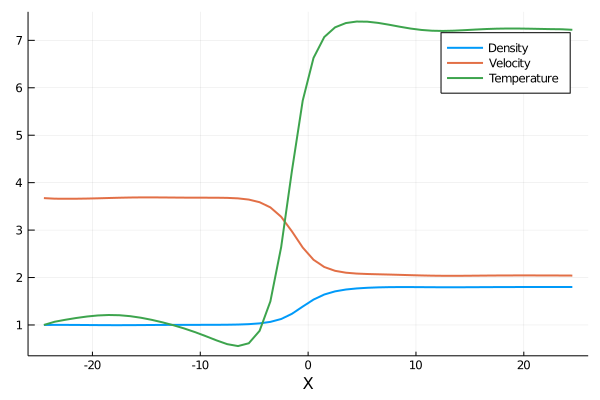

In [204]:
plot_line(ks, ctr)

In [ ]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, ADAM(), cb=cb, maxiters=500)

In [ ]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, LBFGS(), cb=cb, maxiters=200)

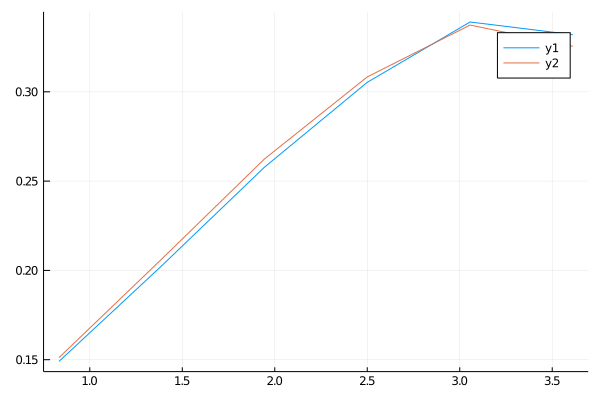

In [126]:
plot(ks.vSpace.u[20:25], (n_ode(ctr[25].f[1:end], res.minimizer) |> Array)[:,1][20:25])
plot!(ks.vSpace.u[20:25], (n_ode(ctr[25].f[1:end], res.minimizer) |> Array)[:,2][20:25])   

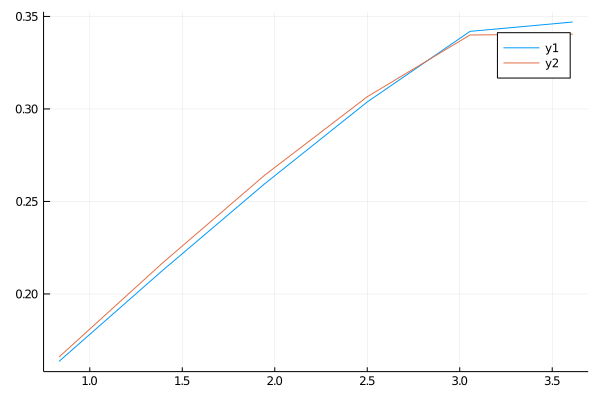

In [135]:
plot(ks.vSpace.u[20:25], data_boltz[24][20:25,1])
plot!(ks.vSpace.u[20:25], data_boltz[24][20:25,2])

In [134]:
data_boltz

48-element Array{Any,1}:
 Float32[5.7274005e-11 5.5454415e-11 5.369263e-11; 2.8984645e-10 2.8063807e-10 2.717222e-10; … ; 4.485936e-14 4.4916087e-14 4.4971015e-14; 7.3742444e-17 7.38573e-17 7.396851e-17]    
 Float32[6.259622e-11 6.060677e-11 5.868055e-11; 3.1841318e-10 3.082933e-10 2.9849503e-10; … ; 4.5106243e-14 4.5185826e-14 4.5262883e-14; 7.421676e-17 7.437893e-17 7.453595e-17]     
 Float32[6.841531e-11 6.6239854e-11 6.4133567e-11; 3.4980777e-10 3.3868464e-10 3.279152e-10; … ; 4.5442698e-14 4.5551155e-14 4.5656167e-14; 7.486701e-17 7.5089325e-17 7.530458e-17]  
 Float32[7.4778496e-11 7.239927e-11 7.0095735e-11; 3.8431489e-10 3.7208714e-10 3.6024844e-10; … ; 4.5890036e-14 4.6034238e-14 4.6173853e-14; 7.573681e-17 7.6034184e-17 7.6322096e-17]
 Float32[8.173777e-11 7.913509e-11 7.661527e-11; 4.2224915e-10 4.0880396e-10 3.9578685e-10; … ; 4.6487154e-14 4.6679633e-14 4.6865984e-14; 7.690564e-17 7.730525e-17 7.769213e-17]    
 Float32[8.935075e-11 8.6502874e-11 8.374577e-11; 4.6396084e

In [100]:
prob = ODEProblem(bgk!, data_init[25], tSpan, data_para[25])
solve(prob, Tsit5(), saveat=tRan)

retcode: Success
Interpolation: 1st order linear
t: 3-element Array{Float32,1}:
 0.0        
 0.035737388
 0.071474776
u: 3-element Array{Array{Float32,1},1}:
 [5.412656e-11, 4.0982032e-10, 2.821535e-9, 1.7663888e-8, 1.00553244e-7, 5.2049285e-7, 2.4498659e-6, 1.048525e-5, 4.080601e-5, 0.00014440373  …  0.14878623, 0.095099285, 0.05527142, 0.02921009, 0.014036993, 0.006133723, 0.002437155, 0.0008805439, 0.00028928625, 8.6419845e-5]
 [5.412656e-11, 4.0982032e-10, 2.821535e-9, 1.7663888e-8, 1.00553244e-7, 5.2049285e-7, 2.4498659e-6, 1.048525e-5, 4.080601e-5, 0.00014440373  …  0.14878623, 0.095099285, 0.05527142, 0.02921009, 0.014036993, 0.006133723, 0.002437155, 0.0008805439, 0.00028928625, 8.6419845e-5]
 [5.412656e-11, 4.0982032e-10, 2.821535e-9, 1.7663888e-8, 1.00553244e-7, 5.2049285e-7, 2.4498659e-6, 1.048525e-5, 4.080601e-5, 0.00014440373  …  0.14878623, 0.095099285, 0.05527142, 0.02921009, 0.014036993, 0.006133723, 0.002437155, 0.0008805439, 0.00028928625, 8.6419845e-5]

In [171]:
prob = ODEProblem(bgk!, ctr[1].f[1:end], (tRan[1], tRan[end]), [ctr[1].f, 0.1])
ftemp = (solve(prob, saveat=tRan) |> Array)[:,end]

36-element Array{Float32,1}:
 0.0          
 0.0          
 0.0          
 0.0          
 0.0          
 0.0          
 6.0e-45      
 3.118e-40    
 8.865546e-36 
 1.3597291e-31
 1.1249062e-27
 5.0199247e-24
 1.2083565e-20
 ⋮            
 0.561946     
 0.44270384   
 0.18812607   
 0.043122273  
 0.005331769  
 0.0003555969 
 1.2792682e-5 
 2.4824598e-7 
 2.5984828e-9 
 1.4671497e-11
 4.468338e-14 
 7.340651e-17 